# Model Training

## Importing Data and Required Packages

In [2]:
# Basic Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer,precision_recall_curve,auc,f1_score
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
print('Setup Complete')



Setup Complete


In [3]:
location = r"E:\ETNMLProject\CreditCardDP\notebook\Dataset\credit_card.csv"

credit_df = pd.read_csv(location,header=0,encoding='latin1',quotechar='"')

In [4]:
credit_df.rename(columns={'default.payment.next.month':'default','PAY_0':'PAY_1'}, inplace=True)

## Data Preprocessing

In [5]:
credit_df['EDUCATION'] = credit_df['EDUCATION'].map({0:4,1:1,2:2,3:3,4:4,5:4,6:4})
credit_df['MARRIAGE'] = credit_df['MARRIAGE'].map({0:3,1:1,2:2,3:3})

In [6]:
# Bin ‘AGE’ data to 6 groups
bins= [21,30,40,50,60,70,80]
labels = list(range(6))
credit_df['AGE'] = pd.cut(credit_df['AGE'],bins=bins, labels=labels,right=False)

# Covert categorical column into integer by extracting the code of the categories
credit_df.AGE = credit_df.AGE.cat.codes

In [7]:
num_col=['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4',
             'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
             'PAY_AMT5', 'PAY_AMT6']

In [8]:
cat_col = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1',
                 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [9]:
X = credit_df.drop(['ID','default'], axis=1)
y = credit_df['default']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [10]:
transformer=ColumnTransformer([('scaled',PowerTransformer(),num_col)],remainder='passthrough')
transformer.fit(X_train)

columns = num_col + cat_col
X_train = pd.DataFrame(transformer.transform(X_train),columns=columns)
X_test = pd.DataFrame(transformer.transform(X_test),columns=columns)

## Evaluation Metrics

* Identifying the defaulter is the main task, therefore positive class is more important than the negative class.
* Due to which we will use area under the precision_recall curve to determine the best model.

In [11]:
def score(y_true,y_probs):
    precision,recall,_=precision_recall_curve(y_true,y_probs)
    return auc(recall,precision)

metric=make_scorer(score,needs_proba=True)

## Algorithm Check

In [12]:
def get_models():
    
    models,names=[],[]
    
    models.append(LogisticRegression())
    names.append('lr')
    
    models.append(KNeighborsClassifier())
    names.append('knn')
    
    models.append(GaussianNB())
    names.append('gnb')
    
    models.append(RandomForestClassifier())
    names.append('rfc')
    
    models.append(XGBClassifier())
    names.append('xgb')
    
    models.append(LGBMClassifier())
    names.append('lgb')
    
    return models,names


In [13]:
def evaluate(X,y):
    
    models,names=get_models()
    results=[]
    
    for i in range(len(models)):
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
        scores=cross_val_score(models[i],X,y,scoring=metric,cv=cv)
        results.append(scores)
        
    plt.boxplot(results,labels=names,showmeans=True)

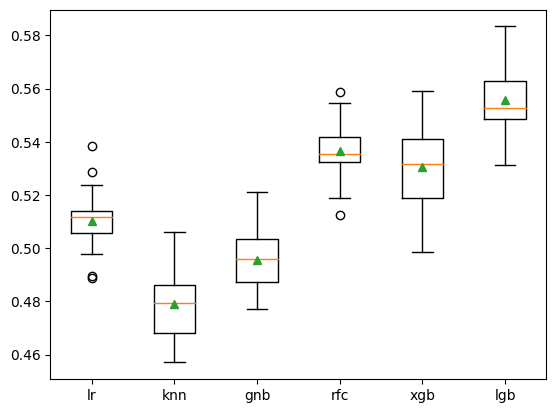

In [14]:
evaluate(X_train,y_train)

* **LightGBM performs well than the other algorithms.** 

## Balancing The Data

* We will use undersampling technique for sampling the data.
* Undersampling will remove the majority class and therefore it will favor the prediction in minority class.

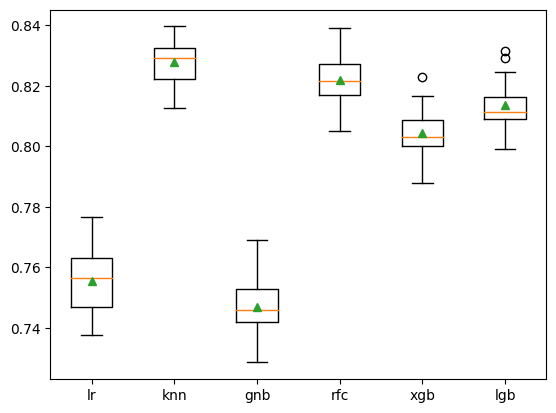

In [16]:
resample = EditedNearestNeighbours()

X_rs, y_rs = resample.fit_resample(X_train, y_train)

evaluate(X_rs,y_rs)

* Data sampling has increased model performances.
* Therefore, now we will use Random Forest Classifier as our final model.

In [17]:
X_train, y_train = X_rs, y_rs

## Feature Selection

<Axes: >

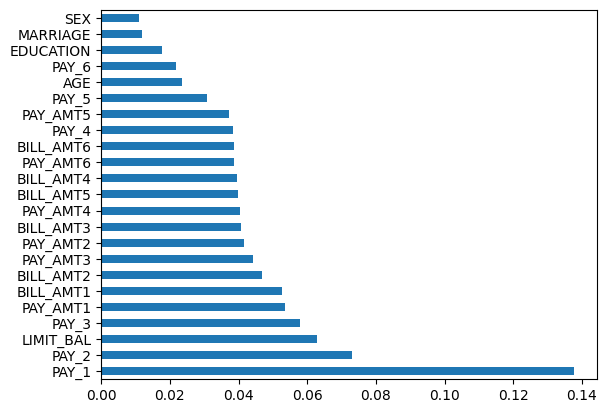

In [18]:
model = RandomForestClassifier()
model.fit(X_rs, y_rs)

# Plotting features

fe = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fe.plot(kind = 'barh')

In [19]:
col = fe.index
col = col.to_list()

In [20]:
results = []

for i in range(8,23):
    model = RandomForestClassifier()
    model.fit(X_train[col[:i]], y_train)
    
    y_probs = model.predict_proba(X_test[col[:i]])
    
    precision, recall, _ = precision_recall_curve(y_test, y_probs[:,1])
    results.append(auc(recall,precision))

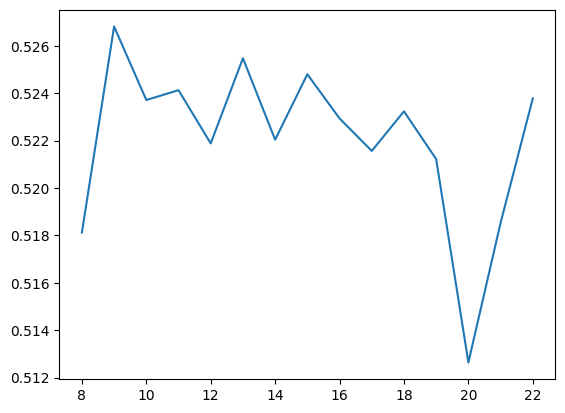

In [21]:
plt.plot([i for i in range(8,23)],results)

* Now we will select 10 features for modelling.

In [22]:
# sf = selected features

sf = ['LIMIT_BAL','PAY_1','PAY_2','PAY_3','BILL_AMT1','BILL_AMT2','BILL_AMT3','PAY_AMT1','PAY_AMT2','PAY_AMT3']

X_train = X_train[sf]
X_test = X_test[sf]

# Hyperparameter Optimization

In [23]:
param_grid = {'n_estimators': range(100,150,10),
              'max_depth': range(3,8),
              'min_samples_split': range(2,10,2)}

cv = StratifiedKFold(n_splits = 5)

model = GridSearchCV(RandomForestClassifier(), param_grid, scoring=metric, n_jobs=1, cv=cv)

model.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': range(3, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(100, 150, 10)},
             scoring=make_scorer(score, needs_proba=True))

In [24]:
model.best_params_

{'max_depth': 7, 'min_samples_split': 8, 'n_estimators': 130}

In [25]:
model.best_score_

0.7948983246883108

## Final Model

In [26]:
model = model.best_estimator_
y_probs = model.predict_proba(X_test)

In [27]:
precision, recall, threshold = precision_recall_curve(y_test, y_probs[:,1])
print(f'Area under precision_recall_curve: {auc(recall,precision)}')

Area under precision_recall_curve: 0.519053532318304


Text(0, 0.5, 'Precision')

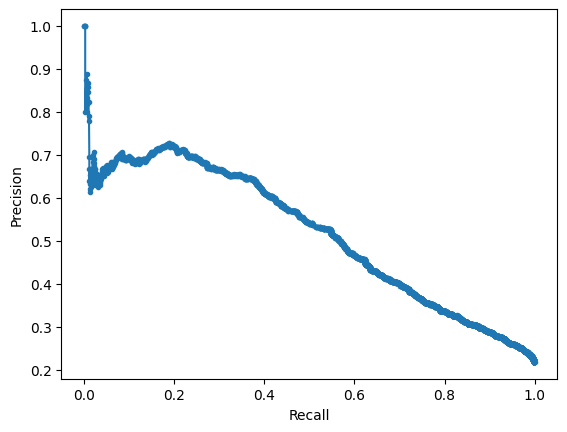

In [28]:
plt.plot(recall, precision, marker='.', label='RandomForestClassifier');

plt.xlabel('Recall')
plt.ylabel('Precision')

# Threshold

In [31]:
f1_score = (5*precision*recall)/(4*precision+recall)

ix = np.argmax(f1_score)

thresh=threshold[ix]

print('Best Threshold=%f, f1_score=%.3f' % (threshold[ix], f1_score[ix]))

Best Threshold=0.163136, f1_score=0.634


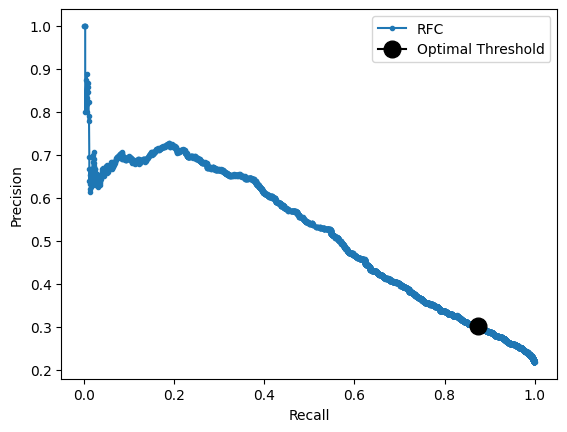

In [32]:
plt.plot(recall, precision, marker='.', label='RFC');
plt.plot(recall[ix],precision[ix],marker='o', markersize=12,color='black',label='Optimal Threshold');

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()

In [33]:
y_pred=(y_probs[:,1]>=thresh)

In [34]:
print(f'Classification_report: \n\n {classification_report(y_test,y_pred)}')

Classification_report: 

               precision    recall  f1-score   support

           0       0.92      0.44      0.59      4687
           1       0.30      0.87      0.45      1313

    accuracy                           0.53      6000
   macro avg       0.61      0.66      0.52      6000
weighted avg       0.79      0.53      0.56      6000



In [35]:
val=['Non-Defaulter','Defaulted']
data=pd.DataFrame(confusion_matrix(y_test,y_pred),columns=val,index=val)

Text(70.72222222222221, 0.5, 'True Label')

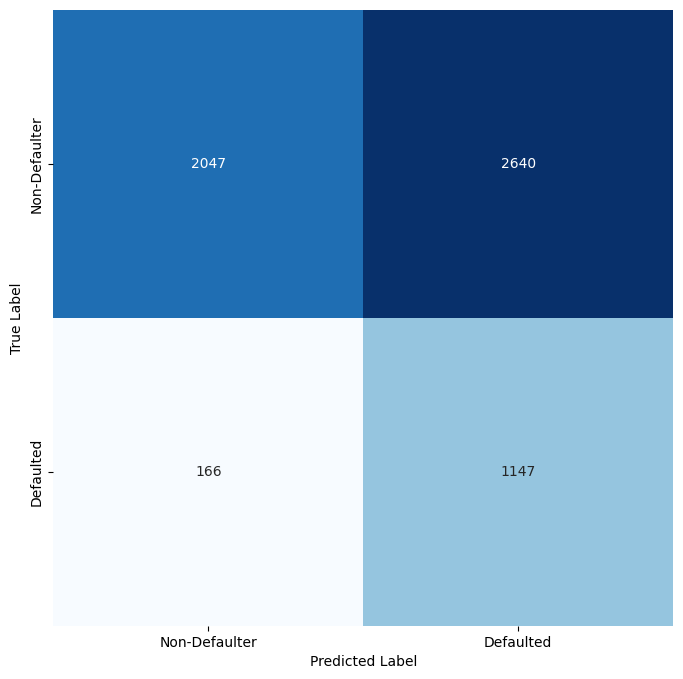

In [36]:
plt.figure(figsize=(8,8))

sns.heatmap(data,annot=True,cbar=False,cmap='Blues',fmt='g');
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

*  We have successfully decreased the False Negatives (defaulter predicted as non-defaulters).
* We also achieved the recall of 0.87 for positive class.